In [1]:
from google.colab import drive

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
%cd drive/MyDrive/USyd/Lab/Projects/Grassmann-ADMM/

/content/drive/MyDrive/USyd/Lab/Projects/Grassmann-ADMM


## Test Federated PCA performance ##

In [3]:
import numpy as np
V_k = np.load('Grassman_Abnormaldetection_KDD_dim_9_std_client_20_iter_1000_lr_0.0001_sub_0.1_localEpochs_30.npy')
# V_k = np.load('Abnormaldetection_KDD_dim_9_std_client_20_iter_100_learningrate_1e-05.npy')
# V_k = np.load('Grassman_Abnormaldetection_KDD_dim_9_std_client_20_iter_1000_lr_0.0001_sub_0.1.npy')
V_k.shape

(34, 9)

In [4]:
# PCA transform with zero mean
def self_pca_transform_with_zero_mean(X_train, V_k):
  return (X_train).dot(V_k)
  
# PCA inverse transform with zero mean
def self_inverse_transform_with_zero_mean(X_pca, V_k):
  return (X_pca.dot(V_k.T))

In [5]:
'''
Import necessary libraries
'''

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
%matplotlib inline

In [6]:
'''
Get KDD dataset from original source and store as a csv file
'''
url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
df = pd.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
'''
Put names on columns of KDD dataset because KDD dataset do not have names in advance
'''
# Assign names for columns
df.columns= [ 'duration','protocol_type', 'service', 'flag', 'src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
'is_host_login', 'is_guest_login','cnt','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

# Show the attributes for KDD dataset
print(df.describe())

            duration     src_bytes     dst_bytes           land  \
count  494021.000000  4.940210e+05  4.940210e+05  494021.000000   
mean       47.979302  3.025610e+03  8.685324e+02       0.000045   
std       707.746472  9.882181e+05  3.304000e+04       0.006673   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  4.500000e+01  0.000000e+00       0.000000   
50%         0.000000  5.200000e+02  0.000000e+00       0.000000   
75%         0.000000  1.032000e+03  0.000000e+00       0.000000   
max     58329.000000  6.933756e+08  5.155468e+06       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   494021.000000  494021.000000  494021.000000      494021.000000   
mean         0.006433       0.000014       0.034519           0.000152   
std          0.134805       0.005510       0.782103           0.015520   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000     

In [8]:
# Choose categorical columns to remove because PCA show good performance with numeric data
# columns_drop = ['num_outbound_cmds','is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login']
columns_drop = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login']

In [9]:
# Check the number of feature before removing
df.columns.shape

(42,)

In [10]:
# Check the type of outcome. 'normal.' represents normal record, while the rest types illustrate attack methods
df['outcome'].unique()

array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
       'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
       'spy.', 'rootkit.'], dtype=object)

In [11]:
# Remove the categorical data
df.drop(columns_drop, axis=1, inplace=True)

In [12]:
# Check number of feature after removing
df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,181,5450,0,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,239,486,0,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,235,1337,0,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,219,1337,0,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,217,2032,0,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [13]:
'''
Get all normal data
'''
df_normal = df[df['outcome']=='normal.']
df_normal.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,181,5450,0,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,239,486,0,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,235,1337,0,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,219,1337,0,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,217,2032,0,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [14]:
'''
Get all abnormal data 
'''
df_abnormal = df[df['outcome']!='normal.']
df_abnormal.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
744,184,1511,2957,0,0,3,0,2,1,0,...,3,1.00,0.00,1.00,0.67,0.0,0.00,0.0,0.0,buffer_overflow.
745,305,1735,2766,0,0,3,0,2,1,0,...,4,1.00,0.00,0.50,0.50,0.0,0.00,0.0,0.0,buffer_overflow.
4049,79,281,1301,0,0,2,0,1,1,0,...,10,1.00,0.00,1.00,0.30,0.0,0.00,0.0,0.1,loadmodule.
4113,25,269,2333,0,0,0,0,0,1,0,...,2,0.03,0.06,0.01,0.00,0.0,0.00,0.0,0.0,perl.
7601,0,0,0,0,0,0,0,0,0,0,...,6,1.00,0.00,0.20,0.33,1.0,0.83,0.0,0.0,neptune.


In [15]:
'''
Data preprocessing 
'''

MIN_MAX = 1
STANDAR = 2
ROBUST = 3

# Choose the preprocessing methods:
def prep_data(dataX, prep_type=1):

  change_dataX = dataX.copy()
  featuresToScale = change_dataX.columns

  if prep_type == MIN_MAX:
    min_max = MinMaxScaler()
    change_dataX.loc[:,featuresToScale] = min_max.fit_transform(change_dataX[featuresToScale])
  elif prep_type == STANDAR:
    sX = StandardScaler(copy=True)
    change_dataX.loc[:,featuresToScale] = sX.fit_transform(change_dataX[featuresToScale])
  else:
    robScaler = RobustScaler()
    change_dataX.loc[:,featuresToScale] = robScaler.fit_transform(change_dataX[featuresToScale])
  
  return change_dataX

In [16]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):
  loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=1) 
  return loss

In [17]:
''' 
Test PCA on 2000 normal data 
'''
# Get the last 10000 normal data
normal_data_10000 = df_normal.iloc[80000:90000].copy()
# Remove the label
normal_data_10000 = normal_data_10000.drop('outcome', axis=1)
# Standardization 
normal_data_10000 = prep_data(normal_data_10000, prep_type=STANDAR)
# Transform data using Federated PCA components
normal_data_pca = self_pca_transform_with_zero_mean(normal_data_10000, V_k)
normal_data_inverse = self_inverse_transform_with_zero_mean(normal_data_pca, V_k)
# Min max normalization before testing to keep balance between features
normal_data_10000 = prep_data(normal_data_10000, prep_type=MIN_MAX)
normal_data_inverse = prep_data(normal_data_inverse, prep_type=MIN_MAX)
# Get anomalous score
abnormal_score = anomalyScores(normal_data_10000, normal_data_inverse)
# print(abnormal_score.shape)
# np.sum(abnormal_score)

In [18]:
index = abnormal_score > 6
len(abnormal_score[index])

489

In [19]:
abnormal_score.max()

13.784428193059716

In [20]:
''' 
Test PCA on 2000 smurf attack data 
'''
smurf_data_2000 = df_abnormal[df_abnormal['outcome']=='smurf.'].iloc[:2000].copy()
smurf_data_2000 = smurf_data_2000.drop('outcome', axis=1)
smurf_data_2000 = prep_data(smurf_data_2000, prep_type=STANDAR)
smurf_data_pca = self_pca_transform_with_zero_mean(smurf_data_2000, V_k)
smurf_data_inverse = self_inverse_transform_with_zero_mean(smurf_data_pca, V_k)
smurf_data_2000 = prep_data(smurf_data_2000, prep_type=MIN_MAX)
smurf_data_inverse = prep_data(smurf_data_inverse, prep_type=MIN_MAX)
abnormal_score = anomalyScores(smurf_data_2000, smurf_data_inverse)
np.sum(abnormal_score)

27208.856220031696

In [21]:
rand_smurf = df_abnormal[df_abnormal['outcome']=='smurf.'].sample(random_state=93).copy()
rand_smurf

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
96634,0,1032,0,0,0,0,0,0,0,0,...,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


In [22]:
def get_abnormaly_scores_on_all_attack(V_k, prep_type=MIN_MAX):
  for name in df_abnormal['outcome'].unique():
    dataX = df_abnormal[df_abnormal['outcome']==name]
    if dataX.shape[0] == 0:
      continue
    if dataX.shape[0] > 2000:
      dataX = dataX.iloc[:2000]
      # dataX = dataX
    dataX = dataX.drop('outcome', axis=1)
    dataX = prep_data(dataX, prep_type=STANDAR)
    data_transform = self_pca_transform_with_zero_mean(dataX, V_k)
    data_inverse = self_inverse_transform_with_zero_mean(data_transform, V_k)
    dataX = prep_data(dataX, prep_type=MIN_MAX)
    data_inverse = prep_data(data_inverse, prep_type=MIN_MAX)
    abnormal_score = anomalyScores(dataX, data_inverse)
    # print(f"abnormal score on {name} with {dataX.shape[0]} samples: {np.sum(abnormal_score)} with min val: {abnormal_score.min()}")
    index = abnormal_score < 6
    # print(len(abnormal_score[index]))

In [23]:
num_samples = get_abnormaly_scores_on_all_attack(V_k, prep_type=STANDAR)
num_samples

In [24]:
'''
Function test on each type of attack
'''
def test_on_random_attack_samples(df_abnormal, V_k, fraction, thres_hold=6):
  num_samples = 0
  total_misclassified_samples = 0
  abnormal_indices_test = []
  for name in df_abnormal['outcome'].unique():
    # Randomly get a portion of attack dataset to test
    dataX = df_abnormal[df_abnormal['outcome']==name].sample(frac=fraction, random_state=1).copy()
    if dataX.shape[0] == 0:
      continue
    # Gather random samples for testing on other algorithms
    dataX_indices = dataX.index.to_list()
    # Concatenate 2 lists of indices
    abnormal_indices_test += dataX_indices
    # Remove the label
    dataX = dataX.drop('outcome', axis=1)
    # Standardization for testing data
    dataX = prep_data(dataX, prep_type=STANDAR)
    # Transform using Federated PCA components
    data_transform = self_pca_transform_with_zero_mean(dataX, V_k)
    data_inverse = self_inverse_transform_with_zero_mean(data_transform, V_k)
    # Min max normalization before testing to keep balance between features
    dataX = prep_data(dataX, prep_type=MIN_MAX)
    data_inverse = prep_data(data_inverse, prep_type=MIN_MAX)
    # Get anomalous score on data
    abnormal_score = anomalyScores(dataX, data_inverse)
    # print(f"abnormal score on {name} with {dataX.shape[0]} samples: {np.sum(abnormal_score)} with min val: {abnormal_score.min()}")
    index = abnormal_score < thres_hold
    # print(len(abnormal_score[index]))
    misclassified_sample_on_attack = len(abnormal_score[index])
    total_misclassified_samples += misclassified_sample_on_attack
    num_samples += dataX.shape[0]
  '''The following code section should only run for the first time to create test data set'''
  # Store test and train data for other algorithms
  # abnormal_test_data = df_abnormal.loc[abnormal_indices_test].copy()
  # abnormal_test_data.to_csv('abnormal_detection_data/test/abnormal_test_34_fea.csv')
  # print(abnormal_test_data.shape)
  # abnormal_train_data = df_abnormal.copy()
  # abnormal_train_data = abnormal_train_data.drop(index=abnormal_indices_test)
  # abnormal_train_data.to_csv('abnormal_detection_data/test/abnormal_train_34_fea.csv')
  # print(abnormal_train_data.shape)
  return  num_samples, total_misclassified_samples

In [25]:
num_samples, misclassified_samples_on_attack = test_on_random_attack_samples(df_abnormal, V_k, fraction=0.02, thres_hold=5.5)
num_samples, misclassified_samples_on_attack

(7934, 21)

In [26]:
'''
Function test on all types of attacks from csv file
'''
def test_on_random_attack_samples_csv(V_k, thres_hold = 6, prep_type=MIN_MAX):
  dataX = pd.read_csv('abnormal_detection_data/test/abnormal_test_34_fea.csv', index_col=False)
  dataX = dataX.drop(['outcome', 'Unnamed: 0'], axis=1)
  dataX = prep_data(dataX, prep_type=STANDAR)
  data_transform = self_pca_transform_with_zero_mean(dataX, V_k)
  data_inverse = self_inverse_transform_with_zero_mean(data_transform, V_k)
  dataX = prep_data(dataX, prep_type=MIN_MAX)
  data_inverse = prep_data(data_inverse, prep_type=MIN_MAX)
  abnormal_score = anomalyScores(dataX, data_inverse)
  # print(f"abnormal score on abnormal data with {dataX.shape[0]} samples: {np.sum(abnormal_score)} with min val: {abnormal_score.min()}")
  index = abnormal_score < thres_hold
  # print(len(abnormal_score[index]))
  num_samples = dataX.shape[0]
  total_misclassified_samples = len(abnormal_score[index])
  return num_samples, total_misclassified_samples

In [27]:
num_samples, misclassified_samples_on_attack = test_on_random_attack_samples_csv(V_k, thres_hold=6)
num_samples, misclassified_samples_on_attack

(7934, 5)

In [28]:
test_abnormal = df_abnormal.head().copy()
random_abnormal = test_abnormal.sample(n=3)
indices = random_abnormal.index
print(indices)
the_rest = test_abnormal.drop(index=indices)
the_rest_indices = the_rest.index.to_list()
print(the_rest_indices)
df_abnormal.shape[0] - 7934

Int64Index([744, 745, 7601], dtype='int64')
[4049, 4113]


388809

In [29]:
'''
Test on another 10000 sample of normal data on the original source
'''
def test_on_normal_data_samples_src(df_normal, V_k, thres_hold=6):
  # Get the last 10000 normal data
  normal_data_10000 = df_normal.iloc[80000:90000].copy()
  # Remove the label
  normal_data_10000 = normal_data_10000.drop('outcome', axis=1)
  # Standardization 
  normal_data_10000 = prep_data(normal_data_10000, prep_type=STANDAR)
  # Transform data using Federated PCA components
  normal_data_pca = self_pca_transform_with_zero_mean(normal_data_10000, V_k)
  normal_data_inverse = self_inverse_transform_with_zero_mean(normal_data_pca, V_k)
  # Min max normalization before testing to keep balance between features
  normal_data_10000 = prep_data(normal_data_10000, prep_type=MIN_MAX)
  normal_data_inverse = prep_data(normal_data_inverse, prep_type=MIN_MAX)
  # Get anomalous score
  abnormal_score = anomalyScores(normal_data_10000, normal_data_inverse)
  # Get the misclassified samples
  index = abnormal_score > thres_hold
  total_normal_samples = normal_data_10000.shape[0]
  return total_normal_samples, len(abnormal_score[index])

In [30]:
total_normal_samples, misclassified_samples = test_on_normal_data_samples_src(df_normal, V_k, thres_hold=6)
total_normal_samples, misclassified_samples

(10000, 489)

In [31]:
'''
Test on another 10000 sample of normal data get data from csv file
'''
def test_on_normal_data_samples_csv(V_k, thres_hold=6):
  normal_data_10000 = pd.read_csv('abnormal_detection_data/test/kdd_10000_34_fea.csv', index_col=False)
  # Standardization 
  normal_data_10000 = prep_data(normal_data_10000, prep_type=STANDAR)
  # Transform data using Federated PCA components
  normal_data_pca = self_pca_transform_with_zero_mean(normal_data_10000, V_k)
  normal_data_inverse = self_inverse_transform_with_zero_mean(normal_data_pca, V_k)
  # Min max normalization before testing to keep balance between features
  normal_data_10000 = prep_data(normal_data_10000, prep_type=MIN_MAX)
  normal_data_inverse = prep_data(normal_data_inverse, prep_type=MIN_MAX)
  # Get anomalous score
  abnormal_score = anomalyScores(normal_data_10000, normal_data_inverse)
  # Get the misclassified samples
  index = abnormal_score > thres_hold
  total_normal_samples = normal_data_10000.shape[0]
  return total_normal_samples, len(abnormal_score[index])

In [32]:
total_normal_samples, misclassified_samples = test_on_normal_data_samples_csv(V_k, thres_hold=6)
total_normal_samples, misclassified_samples

(10000, 489)

In [33]:
def kdd_test(V_k, thres_hold):
  # Get total samples and misclassified samples on normal data
  normal_total_samples, normal_mis_samples = test_on_normal_data_samples_csv(V_k, thres_hold=thres_hold)
  FN = normal_mis_samples
  TN = normal_total_samples - normal_mis_samples
  # Get total samples and misclassified samples on abnormal data
  abnormal_total_samples, abnormal_mis_samples = test_on_random_attack_samples_csv(V_k, thres_hold=thres_hold)
  FP = abnormal_mis_samples
  TP = abnormal_total_samples - abnormal_mis_samples
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  print(f"Precision: {precision_score * 100.0}")
  print(f"Recall: {recall_score * 100.0}")
  print(f"Accuracy score: {accuracy_score * 100.0}")
  print(f"F1 score: {f1_score * 100.0}")

In [34]:
kdd_test(V_k, thres_hold=6)

Precision: 99.93698008570708
Recall: 94.19101924447612
Accuracy score: 97.24545555927288
F1 score: 96.97896281800391


In [61]:
from sklearn.metrics import classification_report, confusion_matrix
def kdd_test(V_k, thres_hold = 6, log = False):

  dataX = pd.read_csv('abnormal_detection_data/test/abnormal_test_34_fea.csv', index_col=False)
  dataX = dataX.drop(['outcome', 'Unnamed: 0'], axis=1)
  dataX = dataX.sample(n=500,random_state=2)
  normal_data_10000 = pd.read_csv('abnormal_detection_data/test/kdd_10000_34_fea.csv', index_col=False)
  data = pd.concat([normal_data_10000, dataX], axis=0)

  data = prep_data(data, prep_type=STANDAR)
  data_transform = self_pca_transform_with_zero_mean(data, V_k)
  data_inverse = self_inverse_transform_with_zero_mean(data_transform, V_k)
  data = prep_data(data, prep_type=MIN_MAX)
  data_inverse = prep_data(data_inverse, prep_type=MIN_MAX)
  abnormal_score = anomalyScores(data, data_inverse)
  index = abnormal_score > thres_hold
  
  df_gt_pred = pd.DataFrame(np.zeros(((len(data),2))))
  df_gt_pred['ground_true'] = np.concatenate([np.zeros(len(normal_data_10000)), np.ones(len(dataX))])
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN) # False positive rate (FPR); False Alarm = FP/N

  if log:
    print(classification_report(df_gt_pred['ground_true'], df_gt_pred['prediction']))
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr

In [ ]:
precision_score, recall_score, accuracy_score, f1_score, fpr = kdd_test(V_k, thres_hold=2, log=True)

In [80]:
lst_rho = np.arange(2,8.5,0.5)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = kdd_test(V_k, thres_hold=rho)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

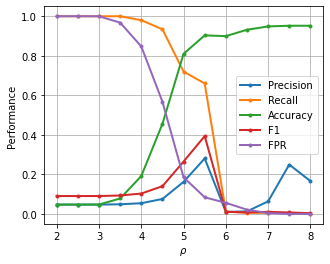

In [81]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
# plt.xticks(xticks)
# plt.legend(loc = 'lower right')
plt.legend()
plt.grid()

# plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
plt.show()

## Test centralized PCA performance ##

In [74]:
# Define the PCA
from pandas.core.common import random_state
from sklearn.decomposition import PCA

def perform_pca(dataX):
  pca = PCA(0.9)

  X_train_PCA = pca.fit_transform(dataX)
  X_train_PCA = pd.DataFrame(data=X_train_PCA, index=dataX.index)

  X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
  X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=dataX.index)

  anomalyScoresPCA = anomalyScores(dataX, X_train_PCA_inverse)
  return pca, anomalyScoresPCA

# PCA transform
def self_pca_transform(X_train, pca):
  return (X_train).dot(pca.components_.T)
  
# PCA inverse transform
def self_inverse_transform(X_pca, pca):
  return (X_pca.dot(pca.components_))

In [75]:
# Get data and labels
dataX = df_normal.drop(['outcome'], axis=1).copy()
dataY = df_normal['outcome'].copy()

In [76]:
'''
Train pca with normal data
'''
train_dataX = prep_data(dataX, prep_type=STANDAR)
pca, abnormalyScore = perform_pca(train_dataX[:80000])

In [71]:
''' 
Test PCA on 2000 normal data 
'''
normal_data_10000 = df_normal.iloc[80000:90000].copy()
normal_data_10000 = normal_data_10000.drop('outcome', axis=1)
normal_data_10000 = prep_data(normal_data_10000, prep_type=STANDAR)
normal_data_pca = self_pca_transform(normal_data_10000, pca)
normal_data_inverse = self_inverse_transform(normal_data_pca, pca)
normal_data_10000 = prep_data(normal_data_10000, prep_type=MIN_MAX)
normal_data_inverse = prep_data(normal_data_inverse, prep_type=MIN_MAX)
abnormal_score = anomalyScores(normal_data_10000, normal_data_inverse)
# np.sum(abnormal_score)

In [72]:
centralized_V_k = pca.components_.T

In [40]:
kdd_test(centralized_V_k, thres_hold=2)

Precision: 100.0
Recall: 95.76342788171394
Accuracy score: 98.04282368685179
F1 score: 97.83587150872434


In [ ]:
precision_score, recall_score, accuracy_score, f1_score, fpr = kdd_test(centralized_V_k, thres_hold=3, log=True)

## Test PCA with mixed test set ##

In [168]:
train_dataX.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,181,5450,0,0,0,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,239,486,0,0,0,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,235,1337,0,0,0,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,219,1337,0,0,0,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,217,2032,0,0,0,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [210]:
from sklearn.metrics import classification_report, confusion_matrix

train_dataX = prep_data(dataX, prep_type=MIN_MAX)
train_dataX = dataX[:80000]
pca, _ = perform_pca(train_dataX)

def kdd_test_mix( log = False):
  pca = PCA(0.99)
  dataX = pd.read_csv('abnormal_detection_data/test/abnormal_test_34_fea.csv', index_col=False)
  dataX = dataX.drop(['outcome', 'Unnamed: 0'], axis=1)
  # dataX = dataX.sample(n=100,random_state=2)
  normal_data_10000 = pd.read_csv('abnormal_detection_data/test/kdd_10000_34_fea.csv', index_col=False)
  data = pd.concat([normal_data_10000[:20], dataX], axis=0)
  print(data.shape)
  data = prep_data(data, prep_type=MIN_MAX)
  data_transform = pca.fit_transform(data)
  data_inverse = pca.inverse_transform(data_transform)
  data = prep_data(data, prep_type=MIN_MAX)
  # data_inverse = prep_data(data_inverse, prep_type=MIN_MAX)
  abnormal_score = anomalyScores(data, data_inverse)
  return abnormal_score
abnormal_score = kdd_test_mix()

(7954, 34)


In [213]:
abnormal_score = pd.DataFrame(abnormal_score, columns=['abnormal score'])
abnormal_score.head()
largest_ = abnormal_score.nlargest(n=7000, columns='abnormal score')
index = largest_.index > 20
len(largest_[index])

6979

## Test Standalone PCA performance ##

In [41]:
# Get data and labels
dataX = df_normal.drop(['outcome'], axis=1).copy()
dataY = df_normal['outcome'].copy()

In [42]:
'''
Train pca with normal data
'''
train_dataX = prep_data(dataX, prep_type=STANDAR)
pca, abnormalyScore = perform_pca(train_dataX[:4000])

In [43]:
''' 
Test PCA on 2000 normal data 
'''
normal_data_10000 = df_normal.iloc[80000:90000].copy()
normal_data_10000 = normal_data_10000.drop('outcome', axis=1)
normal_data_10000 = prep_data(normal_data_10000, prep_type=STANDAR)
normal_data_pca = self_pca_transform(normal_data_10000, pca)
normal_data_inverse = self_inverse_transform(normal_data_pca, pca)
normal_data_10000 = prep_data(normal_data_10000, prep_type=MIN_MAX)
normal_data_inverse = prep_data(normal_data_inverse, prep_type=MIN_MAX)
abnormal_score = anomalyScores(normal_data_10000, normal_data_inverse)
# np.sum(abnormal_score)

In [44]:
standalone_V_k = pca.components_.T

In [45]:
kdd_test(standalone_V_k, thres_hold=2.5)

Precision: 99.97479203428283
Recall: 45.09636704758656
Accuracy score: 46.14140738262518
F1 score: 62.15570269952592
